
# PID Tuner (Standalone Notebook)

This notebook is a single-file, **standalone** environment to test PID parameters efficiently.  
It bundles:
- A minimal in-memory "Service" (mock of `dripline.core.Service`) so no external deps are required.
- Your **PID controller** logic (positional PID with anti-windup hooks, derivative-on-measurement, optional baseline).
- A simple **thermal plant** simulator (1R-1C model) that maps a throttle to heater power.
- A `run_sim(...)` helper to sweep gains quickly and plot PV/SP/throttle.
- Optional CSV export of a simulation run.

> Tip: Edit parameters in the **"Quick start: run a simulation"** cell and re-run.


In [5]:
import sys
sys.executable


'/bin/python3'

In [7]:

# --- Imports & helpers ---
from __future__ import annotations

import math
import time
import datetime
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple, List

import csv
import pandas as pd
import matplotlib.pyplot as plt

# make plots a bit crisper in notebooks
%config InlineBackend.figure_format = 'retina'

def clamp(x: float, lo: float, hi: float) -> float:
    return lo if x < lo else hi if x > hi else x

class ThrowReply(Exception):
    pass


## Minimal in-memory `Service` mock

In [8]:

class Service:
    """
    Minimal drop-in replacement for dripline.core.Service with only get/set APIs.
    Uses a shared in-memory key-value store (dict of dicts) with a configurable 'read_field'.
    """
    _GLOBAL_STORE: Dict[str, Dict[str, Any]] = {}

    def __init__(self, *, read_field: str = "value_cal", store: Optional[Dict[str, Dict[str, Any]]] = None, **kwargs):
        self._read_field = read_field
        # allow passing an external store so controller + tester share the same memory
        if store is None:
            self._store = Service._GLOBAL_STORE
        else:
            self._store = store

    def get(self, key: str) -> Dict[str, Any]:
        return self._store.get(key, {})

    def set(self, key: str, value: Any) -> Dict[str, Any]:
        d = self._store.get(key)
        if d is None:
            d = {}
            self._store[key] = d
        d[self._read_field] = value
        # attach a timestamp for realism
        d["timestamp"] = datetime.datetime.utcnow().strftime('%d/%m/%y %H:%M:%S.%f')
        return d


## PID Controller

In [13]:

class PidController(Service):
    """
    PID control loop (positional PID form with optional baseline offset).

        e = SP - PV
        u = u_offset + Kp*e + Ki*integral(e dt) - Kd*d(PV)/dt

    Public surface mirrors your existing class enough to drop-in here.
    Networking/timeouts/threads are removed for notebook simplicity; the logic is the same.
    """

    def __init__(self,
                 input_channel: str,
                 output_channel: str,
                 check_channel: str,
                 status_channel: str,
                 payload_field: str = 'value_cal',
                 tolerance: float = 0.01,
                 target_value: float = 85.0,
                 proportional: float = 0.0,
                 integral: float = 0.0,
                 differential: float = 0.0,
                 maximum_out: float = 1.0,
                 minimum_out: float = 0.0,
                 delta_out_min: float = 0.001,
                 enable_offset_term: bool = False,
                 minimum_elapsed_time: float = 0.0,
                 # notebook-friendly knobs
                 integral_limit: Optional[float] = None,
                 derivative_smoothing: float = 0.0,
                 max_settle_wait_s: float = 0.5,
                 u_offset_baseline: float = 0.0,
                 store: Optional[Dict[str, Dict[str, Any]]] = None,
                 **kwargs):

        super().__init__(read_field=payload_field, store=store, **kwargs)

        self._input_channel = input_channel
        self._set_channel = output_channel
        self._check_channel = check_channel
        self._status_channel = status_channel
        self.payload_field = payload_field
        self.tolerance = float(tolerance)

        self._target_value = float(target_value)
        self.Kproportional = float(proportional)
        self.Kintegral = float(integral)
        self.Kdifferential = float(differential)

        self.max_current = float(maximum_out)
        self.min_current = float(minimum_out)
        self.min_current_change = float(delta_out_min)

        self.enable_offset_term = bool(enable_offset_term)
        self.u_offset_baseline = float(u_offset_baseline)
        self.max_settle_wait_s = float(max_settle_wait_s)

        self.minimum_elapsed_time = max(0.0, float(minimum_elapsed_time))

        self._integral = 0.0
        self._int_limit = None if integral_limit is None else abs(float(integral_limit))
        self._alpha_d = clamp(float(derivative_smoothing), 0.0, 1.0)
        self._ema_dpvdt = 0.0
        self._last_data = {'value': None, 'time': None}
        self._force_reprocess = False

        # initialize status + old_current sensibly if not present
        if self.get(self._status_channel).get(self.payload_field) is None:
            self.set(self._status_channel, "enabled")

        self.__validate_status()
        try:
            self._old_current = self.__get_current()
        except Exception:
            self._old_current = 0.0
            self.set(self._check_channel, self._old_current)

    # ---- Public surface ----
    @property
    def target_value(self) -> float:
        return self._target_value

    @target_value.setter
    def target_value(self, value: float) -> None:
        self._target_value = float(value)
        self._integral = 0.0
        self._force_reprocess = True

    def set_current(self, value: float) -> None:
        # write both set_channel and check_channel in this notebook (no hardware lag model here)
        self.set(self._set_channel, float(value))
        self.set(self._check_channel, float(value))

    def process_new_value(self, value: float, timestamp: datetime.datetime) -> float:
        """Run one PID step. Returns the new command `u`."""
        last_time = self._last_data['time']
        last_value = self._last_data['value']

        if last_time is None:
            self._last_data = {'value': float(value), 'time': timestamp}
            return self._old_current

        dt = (timestamp - last_time).total_seconds()
        if dt <= 0:
            dt = max(self.minimum_elapsed_time, 1e-6)
        if dt < self.minimum_elapsed_time and not self._force_reprocess:
            return self._old_current
        self._force_reprocess = False

        # error + integral
        e = self._target_value - float(value)
        self._integral += e * dt
        if self._int_limit is not None:
            self._integral = clamp(self._integral, -self._int_limit, self._int_limit)

        # derivative on measurement
        if last_value is None:
            d_pv_dt = 0.0
        else:
            raw_d = (float(value) - float(last_value)) / dt
            d_pv_dt = raw_d
            # TODO: Check this
            # self._ema_dpvdt = self._alpha_d * self._ema_dpvdt + (1 - self._alpha_d) * raw_d
            # d_pv_dt = self._ema_dpvdt if self._alpha_d > 0 else raw_d

        self._last_data = {'value': float(value), 'time': timestamp}

        baseline = (self._old_current if self.enable_offset_term else 0.0) + self.u_offset_baseline
        delta_terms = self.Kproportional * e + self.Kintegral * self._integral - self.Kdifferential * d_pv_dt
        u = baseline + delta_terms

        u_sat = clamp(u, self.min_current, self.max_current)
        if u != u_sat and self.Kintegral > 0.0:
            # back-calculation
            self._integral += (u_sat - u) / self.Kintegral
            # TODO: Check this
            # if self._int_limit is not None:
            #     self._integral = clamp(self._integral, -self._int_limit, self._int_limit)
            u = u_sat
        else:
            u = u_sat

        if abs(u - self._old_current) < self.min_current_change:
            return self._old_current

        self.set_current(u)
        self._old_current = u
        return u

    # ---- Private helpers ----
    def __get_current(self) -> float:
        d = self.get(self._check_channel)
        if not d:
            raise ThrowReply("current read failed")
        v = d.get(self.payload_field)
        return float(v)

    def __validate_status(self) -> None:
        value = self.get(self._status_channel).get(self.payload_field)
        if not value:
            raise ThrowReply(f"Invalid status on {self._status_channel}")


## Thermal plant (1R-1C) — `PidLoopTester` analogue

In [14]:

class PidLoopTester(Service):
    """
    1R-1C thermal model with a throttle->power map.

    C dT/dt = P_heater(t) - (T - T_env)/R_th + D(t)
    throttle in 'current' mode is Amps; power = eta * R_heater * I^2
    """
    def __init__(self,
                 time_step=0.1,
                 T0=40.0,
                 C=10.0,
                 R_th=1.0,
                 T_env=40.0,
                 throttle_mode='current',  # 'current' or 'power'
                 I_max=2.5,
                 R_heater=6.0,
                 eta=0.95,
                 P_max=100.0,
                 read_field='value_cal',
                 throttle_endpoint="throttle",
                 sensor_endpoint="sensor",
                 store: Optional[Dict[str, Dict[str, Any]]] = None,
                 **kwargs):
        super().__init__(read_field=read_field, store=store, **kwargs)

        self.dt = float(time_step)
        self.C = float(C)
        self.Rth = float(R_th)
        self.Tenv = float(T_env)

        self.mode = str(throttle_mode).lower()
        self.Imax = float(I_max)
        self.Rheater = float(R_heater)
        self.eta = float(eta)
        self.Pmax = float(P_max)

        self.throttle_key = throttle_endpoint
        self.sensor_key = sensor_endpoint

        # init endpoints
        self.set(self.sensor_key, float(T0))
        self.set(self.throttle_key, 0.0)

        self.t = 0.0

    # I/O
    def get_sensor_value(self) -> float:
        return float(self.get(self.sensor_key).get(self._read_field, 0.0))

    def set_sensor_value(self, value: float) -> None:
        self.set(self.sensor_key, float(value))

    def get_throttle_value(self) -> float:
        return float(self.get(self.throttle_key).get(self._read_field, 0.0))

    def set_throttle_value(self, value: float) -> None:
        self.set(self.throttle_key, float(value))

    # mapping
    def _power_from_throttle(self, throttle_value: float) -> float:
        if self.mode == 'current':
            I = clamp(float(throttle_value), 0.0, self.Imax)
            return self.eta * self.Rheater * (I**2)
        elif self.mode == 'power':
            return clamp(float(throttle_value), 0.0, self.Pmax)
        else:
            raise ThrowReply("throttle_mode must be 'current' or 'power'")

    def external_disturbance(self, t: float) -> float:
        # customize as needed
        if 10.0 < t < 15.0:
            return -1.0
        elif 20.0 < t < 25.0:
            return +0.5
        elif t > 40.0:
            return 0.2 * math.sin(t)
        else:
            return 0.0

    def step(self) -> None:
        T = self.get_sensor_value()
        throttle = self.get_throttle_value()
        P_heater = self._power_from_throttle(throttle)
        P_loss = (T - self.Tenv) / self.Rth
        D = self.external_disturbance(self.t)
        dT_dt = (P_heater - P_loss + D) / self.C
        T_new = T + self.dt * dT_dt
        self.set_sensor_value(T_new)
        self.t += self.dt


## Simulation harness: `run_sim(...)`

In [17]:

def run_sim(
    duration_s: float = 60.0,
    controller_period_s: float = 0.1,
    # plant
    T0: float = 40.0, 
    C: float = 10.0, 
    R_th: float = 1.0, 
    T_env: float = 40.0,
    I_0: float = 0.0,
    throttle_mode: str = "current", 
    I_max: float = 2.5, 
    R_heater: float = 6.0, 
    eta: float = 0.95, 
    P_max: float = 100.0,
    dt: float = 0.05,
    # controller
    SP: float = 85.0, # target temperature
    Kp: float = 0.01, # proportional gain
    Ki: float = 0.002, # integral gain
    Kd: float = 0.0, # derivative gain
    u_min: float = 0.0, # minimum throttle
    u_max: float = 2.5, # maximum throttle
    du_min: float = 1e-3, # minimum change in throttle
    derivative_smoothing: float = 0.0, # derivative smoothing
    int_limit: Optional[float] = None, # integral limit
    enable_offset_term: bool = False, # enable offset term
    baseline_offset: float = 0.0, # baseline offset
    # logging/export
    csv_path: Optional[str] = None, # path to save CSV
    ) -> pd.DataFrame:
    """
    Run a closed-loop simulation and return a DataFrame with time, PV, SP, throttle.
    Optionally writes a CSV if csv_path is given.
    """
    # shared store
    store: Dict[str, Dict[str, Any]] = {}
    read_field = "value_cal"
    sensor_key = "sensor_value.sensor"
    throttle_key = "actuator.throttle"
    check_key = "actuator.readback"
    status_key = "status.enabled"

    # seed status + readback
    store[status_key] = {read_field: "enabled"}
    store[check_key] = {read_field: 0.0}

    # plant + controller
    plant = PidLoopTester(
        time_step=dt, T0=T0, C=C, R_th=R_th, T_env=T_env,
        throttle_mode=throttle_mode, I_max=I_max, R_heater=R_heater, eta=eta, P_max=P_max,
        read_field=read_field, throttle_endpoint=throttle_key, sensor_endpoint=sensor_key, store=store
    )

    pid = PidController(
        input_channel=sensor_key, output_channel=throttle_key, check_channel=check_key, status_channel=status_key,
        payload_field=read_field, tolerance=0.01, target_value=SP, proportional=Kp, integral=Ki, differential=Kd,
        maximum_out=u_max, minimum_out=u_min, delta_out_min=du_min, enable_offset_term=enable_offset_term,
        minimum_elapsed_time=controller_period_s, derivative_smoothing=derivative_smoothing,
        integral_limit=int_limit, u_offset_baseline=baseline_offset, store=store
    )

    # sim loop
    t = 0.0
    next_ctl = 0.0
    rows: List[Tuple[float, float, float, float]] = []
    while t <= duration_s + 1e-12:
        # controller tick
        if t >= next_ctl:
            PV = plant.get_sensor_value()
            ts = datetime.datetime.utcnow()
            u = pid.process_new_value(PV, ts)
            plant.set_throttle_value(u)  # write the command
            next_ctl += controller_period_s

        # plant evolves
        plant.step()

        # log
        rows.append((t, plant.get_sensor_value(), SP, plant.get_throttle_value()))
        t += dt
    time.sleep(dt) 

    import pandas as pd
    df = pd.DataFrame(rows, columns=["time_s", "PV", "SP", "throttle"])

    if csv_path:
        df.to_csv(csv_path, index=False)

    return df


## Quick start: run a simulation

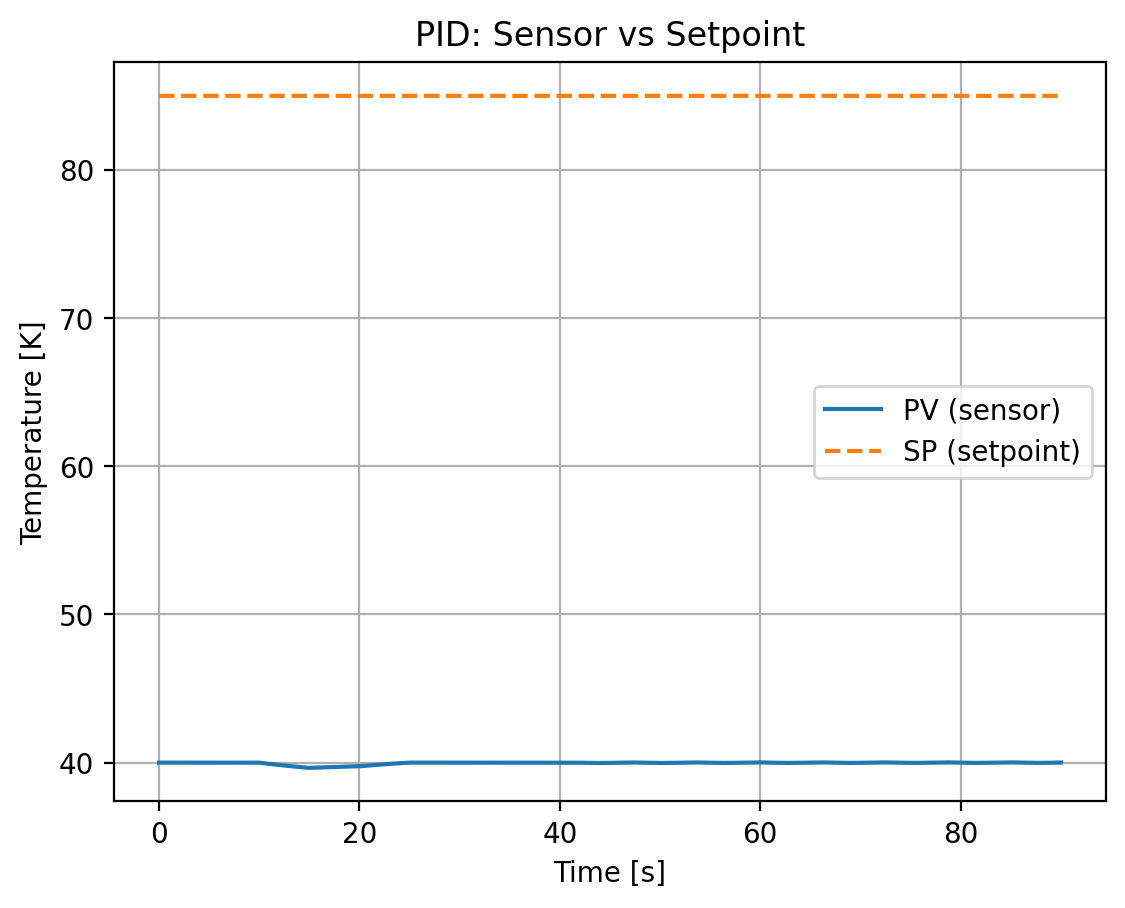

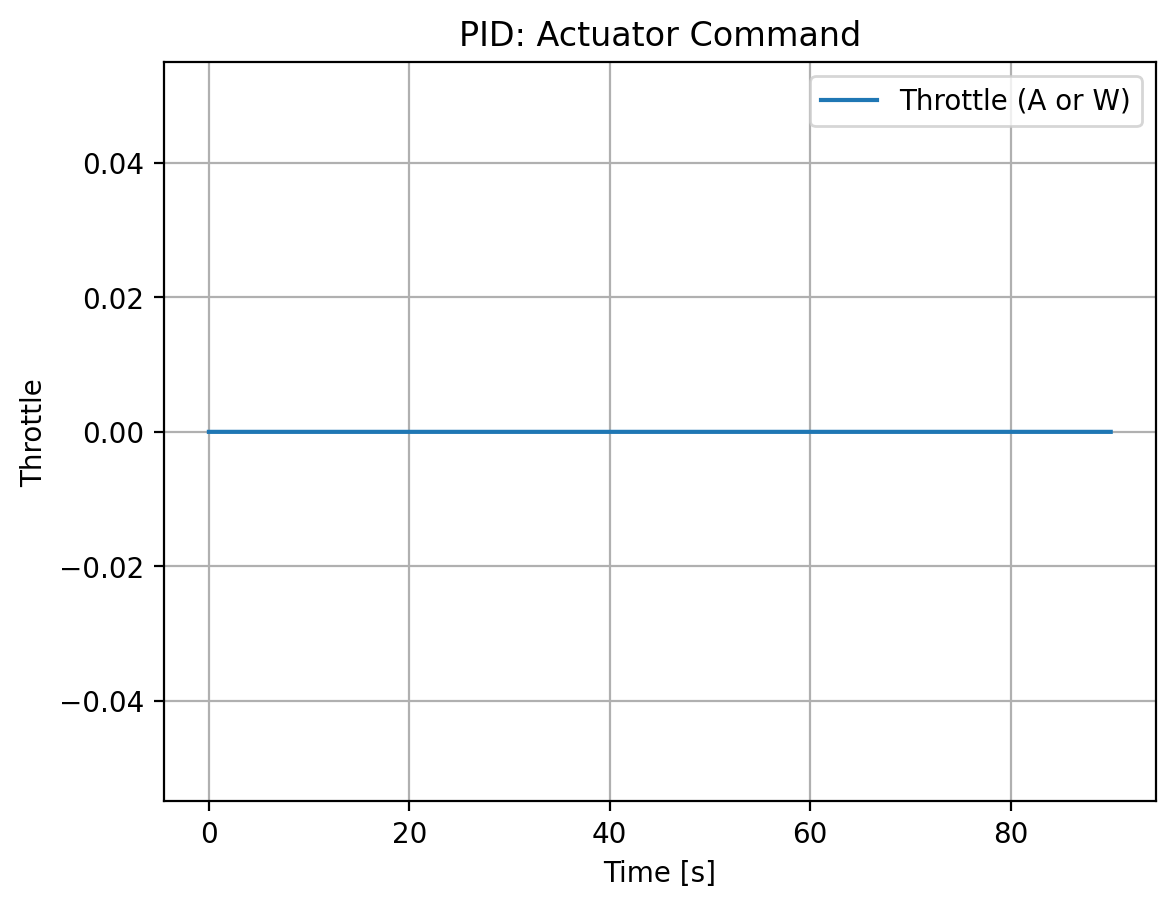

,time_s,PV,SP,throttle
0,0.00,40.0,85.0,0.0
1,0.05,40.0,85.0,0.0
2,0.10,40.0,85.0,0.0
3,0.15,40.0,85.0,0.0
4,0.20,40.0,85.0,0.0


In [18]:

# Example: mild heating from 40 K toward 85 K using current mode (I_max=2.5 A)
df = run_sim(
    duration_s=90.0,
    controller_period_s=0.1,
    T0=40.0, C=12.0, R_th=1.2, T_env=40.0,
    throttle_mode="current", I_max=2.5, R_heater=6.0, eta=0.95,
    dt=0.05,
    SP=85.0, Kp=0.12, Ki=0.02, Kd=0.0,
    u_min=0.0, u_max=2.5, du_min=0.001,
    derivative_smoothing=0.2,
    int_limit=200.0,
    enable_offset_term=False,
    baseline_offset=0.0,
    csv_path=None
)

# Plot PV vs SP
plt.figure()
plt.plot(df["time_s"], df["PV"], label="PV (sensor)")
plt.plot(df["time_s"], df["SP"], linestyle="--", label="SP (setpoint)")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.title("PID: Sensor vs Setpoint")
plt.legend()
plt.grid(True)
plt.show()

# Plot throttle
plt.figure()
plt.plot(df["time_s"], df["throttle"], label="Throttle (A or W)")
plt.xlabel("Time [s]")
plt.ylabel("Throttle")
plt.title("PID: Actuator Command")
plt.legend()
plt.grid(True)
plt.show()

df.head()


## Optional: simple metrics

In [17]:

def analyze_run(df, tol=0.5, window_s=5.0):
    """
    Compute a rough settling time and overshoot.
    - tol: absolute tolerance band around SP to consider 'settled'
    - window_s: must stay within band for this trailing window
    """
    sp = df["SP"].iloc[-1]
    t = df["time_s"].values
    pv = df["PV"].values
    # overshoot
    overshoot = max(0.0, (pv.max() - sp))

    # settling time
    settle_t = None
    import numpy as np
    for i in range(len(t)):
        t0 = t[i]
        mask = (t >= t0) & (t <= t0 + window_s)
        if mask.sum() == 0:
            continue
        band_ok = (np.abs(pv[mask] - sp) <= tol).all()
        if band_ok:
            settle_t = t0
            break

    return {"overshoot_abs": overshoot, "settling_time_s": settle_t}

analyze_run(df)


{'overshoot_abs': 0.0, 'settling_time_s': None}

## Export to CSV (optional)

In [ ]:

# Example of saving the last run:
# df.to_csv("pid_last_run.csv", index=False)
# print("Saved to pid_last_run.csv")
